In [169]:
import json
import matplotlib.pyplot as plt
import numpy as np


WINDOW_SIZE = 10
NUM_SIGMAS = 2
SUB_PLOT_ROWS = 1
SUB_PLOT_COLS = 2

with open("data/baby2.json") as datafile2:
    data_baby2 = json.load(datafile2)
with open("data/baby1.json") as datafile1:
    data_baby1 = json.load(datafile1)

datasets = [data_baby1, data_baby2]
dataset_names = ["baby1", "baby2"]

time_msec_datasets = []
contraction_length_msec_datasets = []
x_bound_datasets = []
y_bound_datasets = []
delivery_time_msec_datasets = []
delivery_line_x_datasets = []
delivery_line_y_datasets = []
for data in datasets:
  time_msec = []
  contraction_length_msec = []
  for entry in data["contractions"]:
      time_msec.append(entry["startTime"])
      contraction_length_msec.append(entry["duration"])

  time_msec = np.array(time_msec)
  contraction_length_msec = np.array(contraction_length_msec)
  indexes = time_msec.argsort()
  time_msec = time_msec[indexes]
  contraction_length_msec = contraction_length_msec[indexes]

  x_bound = int(max(time_msec)*1.3)
  y_bound = int(max(contraction_length_msec)*1.3)

  delivery_time_msec = data["deliveryTime"]
  delivery_line_x = []
  delivery_line_y = []
  for i in range(0, y_bound, 1000):
    delivery_line_x.append(delivery_time_msec)
    delivery_line_y.append(i)
  
  time_msec_datasets.append(time_msec)
  contraction_length_msec_datasets.append(contraction_length_msec)
  x_bound_datasets.append(x_bound)
  y_bound_datasets.append(y_bound)
  delivery_time_msec_datasets.append(delivery_time_msec)
  delivery_line_x_datasets.append(delivery_line_x)
  delivery_line_y_datasets.append(delivery_line_y)


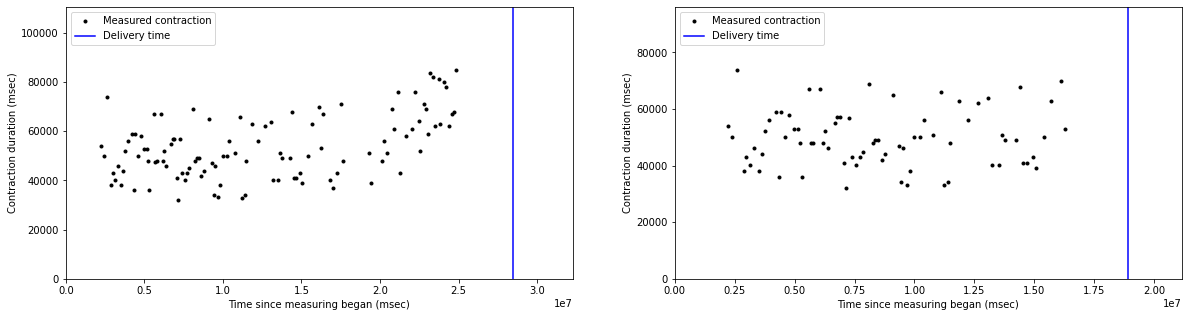

In [170]:

plt.rcParams["figure.figsize"] = (20,5)

def plot_datasets():
  for i in range(0, len(datasets)):
    plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
    plt.xlim([0, x_bound_datasets[i]])
    plt.ylim([0, y_bound_datasets[i]])
    plt.plot(time_msec_datasets[i], contraction_length_msec_datasets[i], '.', color='black', label='Measured contraction')
    plt.plot(delivery_line_x_datasets[i], delivery_line_y_datasets[i], '-', color='blue', label='Delivery time')
    plt.legend()
    plt.xlabel("Time since measuring began (msec)")
    plt.ylabel("Contraction duration (msec)")
plot_datasets()

Steve Mould's video says:
> They are not very predictable. They're quite spread out, but as time goes on it gets more predictable - it's more bunched up there. And there's a wonderful thing you can do with excel. You can track how that changes as a function of time. Is the standard deviation basically. So I was able to create sort of an envelope of possible contraction lengths and then project that into the future. [...] there is point in the future at which my wife's contractions become perfectly regular and that's at 20:55. And it's my working hypothesis that that is the moment my child will be born.

However, I'm not sure how to apply that. My guess is that he used a sliding 'window' and calculated the standard deviation on those windows.

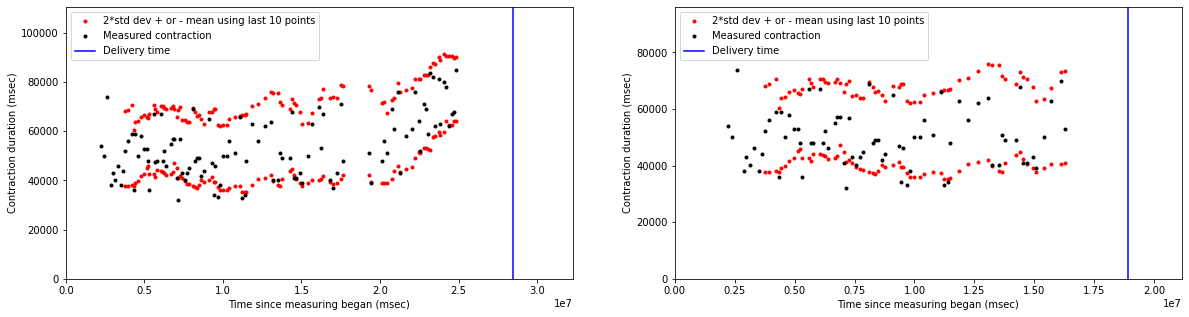

In [171]:


means_datasets = []
standard_devs_datasets = []
mean_upper_datasets = []
mean_lower_datasets = []
windowed_time_msec_datasets = []
for i in range(0, len(datasets)):
  means = []
  standard_devs = []
  mean_upper = []
  mean_lower = []
  windowed_time_msec = time_msec_datasets[i][WINDOW_SIZE-1:len(contraction_length_msec_datasets[i])]
  for j in range(WINDOW_SIZE-1, len(contraction_length_msec_datasets[i])):
      contraction_sub_array = contraction_length_msec_datasets[i][j-WINDOW_SIZE+1:j+1]
      mean = np.mean(contraction_sub_array)
      standard_dev = np.std(contraction_sub_array)
      means.append(mean)
      standard_devs.append(standard_dev)
      mean_upper.append(mean+NUM_SIGMAS*standard_dev)
      mean_lower.append(mean+NUM_SIGMAS-standard_dev)
  means_datasets.append(means)
  standard_devs_datasets.append(standard_devs)
  mean_upper_datasets.append(mean_upper)
  mean_lower_datasets.append(mean_lower)
  windowed_time_msec_datasets.append(windowed_time_msec)

for i in range(0, len(datasets)):
  plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
  label_str = str(NUM_SIGMAS) + "*std dev + or - mean using last " + str(WINDOW_SIZE) + " points"
  plt.plot(windowed_time_msec_datasets[i], mean_upper_datasets[i], '.', color='red', label=label_str)
  plt.plot(windowed_time_msec_datasets[i], mean_lower_datasets[i], '.', color='red')
plot_datasets()

If you plotted a curve through the the upper and lower bounds from 2 std devs from the mean (red dots), it looks like they could intersect near the blue vertical bar (delivery time).

First let's try an exponential model.

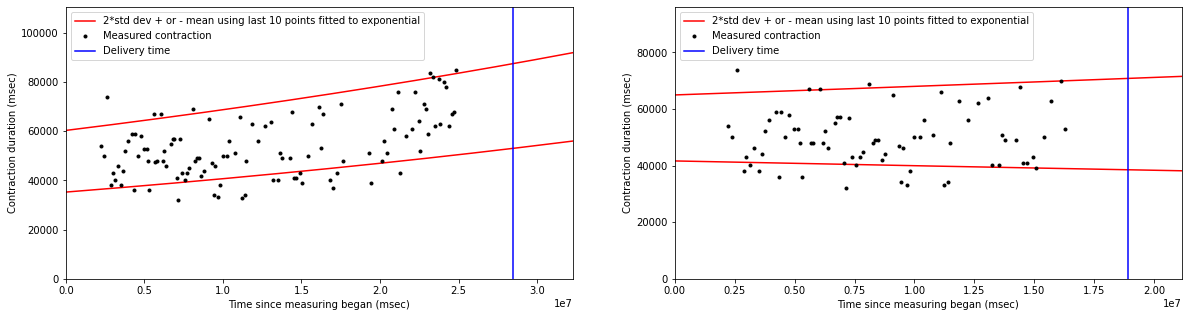

In [172]:

def plot_exponential(xs, ys, label=None):
  log_ys = np.log(ys)
  curve_fit_ys = np.polyfit(xs, log_ys, 1)
  projected_xs = []
  for j in range(0, int(max(xs)*2), 1000):
    projected_xs.append(j)
  projected_xs = np.array(projected_xs)
  projected_ys = np.exp(curve_fit_ys[1]) * np.exp(curve_fit_ys[0]*projected_xs)
  if label == None:
    plt.plot(projected_xs, projected_ys, '-', color='red')
  else:
    plt.plot(projected_xs, projected_ys, '-', color='red', label=label_str)


for i in range(0, len(datasets)):
  plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
  label_str = str(NUM_SIGMAS) + "*std dev + or - mean using last " + str(WINDOW_SIZE) + " points fitted to exponential"
  plot_exponential(windowed_time_msec_datasets[i], mean_upper_datasets[i], label=label_str)
  plot_exponential(windowed_time_msec_datasets[i], mean_lower_datasets[i])
plot_datasets()


The exponential model didn't intersect in Steve Mould's video.


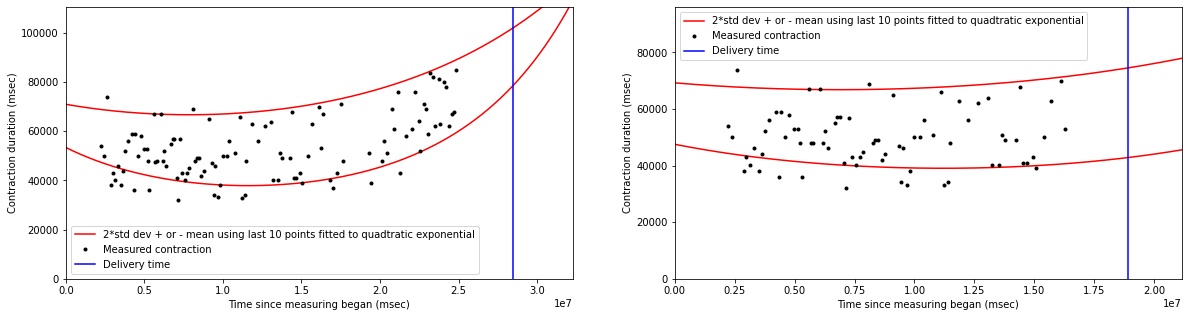

In [173]:
def plot_quadratic_exponential(xs, ys, label=None):
  log_ys = np.log(ys)
  curve_fit_ys = np.polyfit(xs, log_ys, 2)
  projected_xs = []
  for j in range(0, int(max(xs)*2), 1000):
    projected_xs.append(j)
  projected_xs = np.array(projected_xs)
  projected_ys = np.exp(curve_fit_ys[2]) * np.exp(curve_fit_ys[1]*projected_xs) * np.exp(curve_fit_ys[0]*projected_xs*projected_xs)
  if label == None:
    plt.plot(projected_xs, projected_ys, '-', color='red')
  else:
    plt.plot(projected_xs, projected_ys, '-', color='red', label=label_str)

for i in range(0, len(datasets)):
  plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
  label_str = str(NUM_SIGMAS) + "*std dev + or - mean using last " + str(WINDOW_SIZE) + " points fitted to quadtratic exponential"
  plot_quadratic_exponential(windowed_time_msec_datasets[i], mean_upper_datasets[i], label=label_str)
  plot_quadratic_exponential(windowed_time_msec_datasets[i], mean_lower_datasets[i])
plot_datasets()


Now I'm trying to see if a linear model will do better.

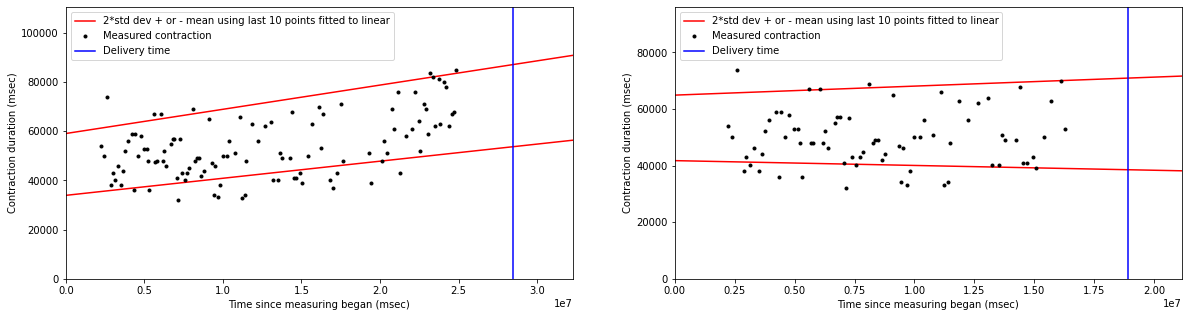

In [174]:
def plot_linear(xs, ys, label=None):
  curve_fit_ys = np.polyfit(xs, ys, 1)
  projected_xs = []
  for j in range(0, int(max(xs)*2), 1000):
    projected_xs.append(j)
  projected_xs = np.array(projected_xs)
  projected_ys = curve_fit_ys[1] + curve_fit_ys[0]*projected_xs
  if label == None:
    plt.plot(projected_xs, projected_ys, '-', color='red')
  else:
    plt.plot(projected_xs, projected_ys, '-', color='red', label=label_str)

for i in range(0, len(datasets)):
  plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
  label_str = str(NUM_SIGMAS) + "*std dev + or - mean using last " + str(WINDOW_SIZE) + " points fitted to linear"
  plot_linear(windowed_time_msec_datasets[i], mean_upper_datasets[i], label=label_str)
  plot_linear(windowed_time_msec_datasets[i], mean_lower_datasets[i])
plot_datasets()


The linear model did not intersect anywhere close to the delivery time.

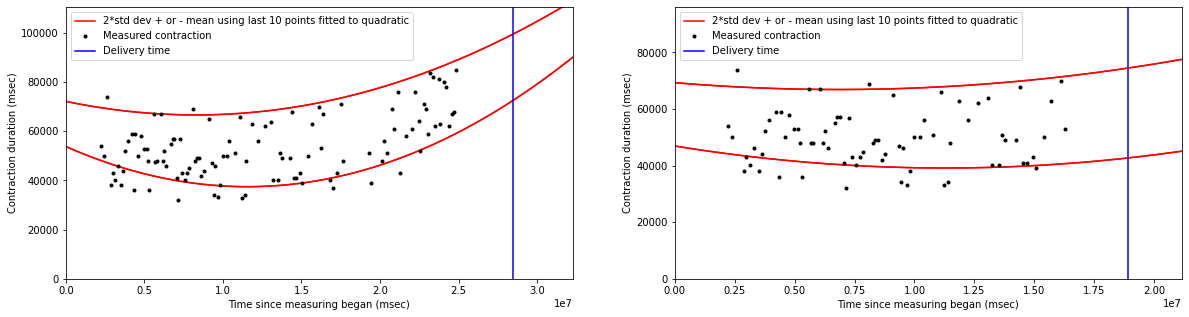

In [175]:
def plot_quadratic(xs, ys, label=None):
  curve_fit_ys = np.polyfit(xs, ys, 2)
  projected_xs = []
  for j in range(0, int(max(xs)*2), 1000):
    projected_xs.append(j)
  projected_xs = np.array(projected_xs)
  projected_ys = curve_fit_ys[2] + curve_fit_ys[1]*projected_xs + curve_fit_ys[0]*projected_xs*projected_xs
  plt.plot(projected_xs, projected_ys, '-', color='red')
  if label == None:
    plt.plot(projected_xs, projected_ys, '-', color='red')
  else:
    plt.plot(projected_xs, projected_ys, '-', color='red', label=label_str)

for i in range(0, len(datasets)):
  plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
  label_str = str(NUM_SIGMAS) + "*std dev + or - mean using last " + str(WINDOW_SIZE) + " points fitted to quadratic"
  plot_quadratic(windowed_time_msec_datasets[i], mean_upper_datasets[i], label=label_str)
  plot_quadratic(windowed_time_msec_datasets[i], mean_lower_datasets[i])
plot_datasets()



Trying to do windowed again, but do not repeat. Only keep #points/10 instead of #points-10


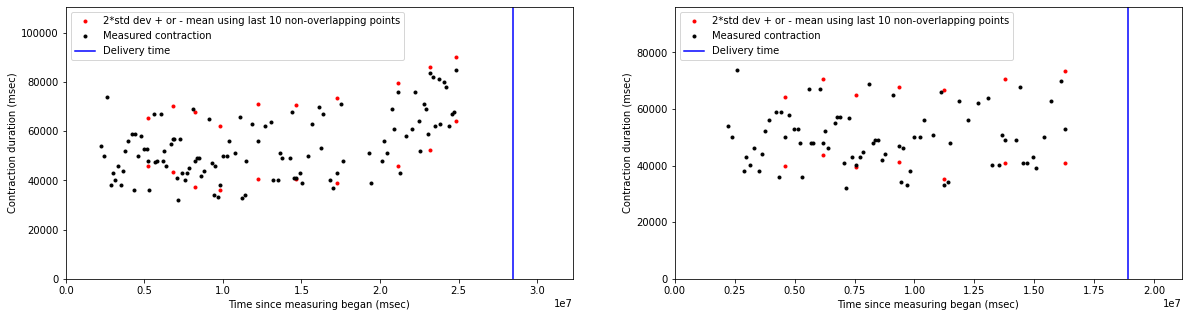

In [176]:

divided_windowed_time_msec_datasets = []
divided_window_mean_upper_datasets = []
divided_window_mean_lower_datasets = []
for i in range(0, len(datasets)):
  divided_window_means = []
  divided_window_standard_devs = []
  divided_window_mean_upper = []
  divided_window_mean_lower = []
  divided_windowed_time_msec = []
  for j in range(len(contraction_length_msec_datasets[i])-1, 9, -WINDOW_SIZE):
    contraction_sub_array = contraction_length_msec_datasets[i][j-WINDOW_SIZE+1:j+1]
    mean = np.mean(contraction_sub_array)
    standard_dev = np.std(contraction_sub_array)
    divided_window_means.append(mean)
    divided_window_standard_devs.append(standard_dev)
    divided_window_mean_upper.append(mean+NUM_SIGMAS*standard_dev)
    divided_window_mean_lower.append(mean+NUM_SIGMAS-standard_dev)
    divided_windowed_time_msec.append(time_msec_datasets[i][j])
  divided_windowed_time_msec_datasets.append(divided_windowed_time_msec)
  divided_window_mean_upper_datasets.append(divided_window_mean_upper)
  divided_window_mean_lower_datasets.append(divided_window_mean_lower)

for i in range(0, len(datasets)):
  plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
  label_str = str(NUM_SIGMAS) + "*std dev + or - mean using last " + str(WINDOW_SIZE) + " non-overlapping points"
  plt.plot(divided_windowed_time_msec_datasets[i], divided_window_mean_upper_datasets[i], '.', color='red', label=label_str)
  plt.plot(divided_windowed_time_msec_datasets[i], divided_window_mean_lower_datasets[i], '.', color='red')
plot_datasets()

Exponential model with divided windows instead of repeated windows:

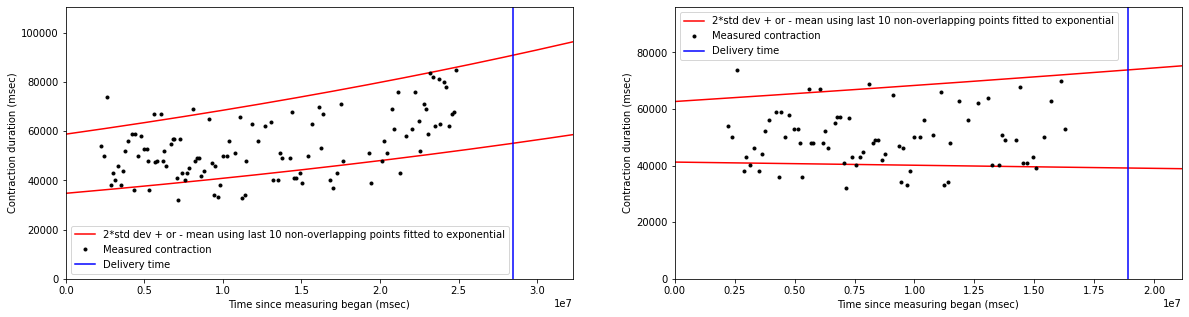

In [177]:

for i in range(0, len(datasets)):
  plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
  label_str = str(NUM_SIGMAS) + "*std dev + or - mean using last " + str(WINDOW_SIZE) + " non-overlapping points fitted to exponential"
  plot_exponential(divided_windowed_time_msec_datasets[i], divided_window_mean_upper_datasets[i], label=label_str)
  plot_exponential(divided_windowed_time_msec_datasets[i], divided_window_mean_lower_datasets[i])
plot_datasets()


Looks like the exponential model, even with the non-overlaping windows didn't work.

Next, we will try to make a convex hull.
We'll use the top points for the top line.
We'll use the bottom points for the bottom line.

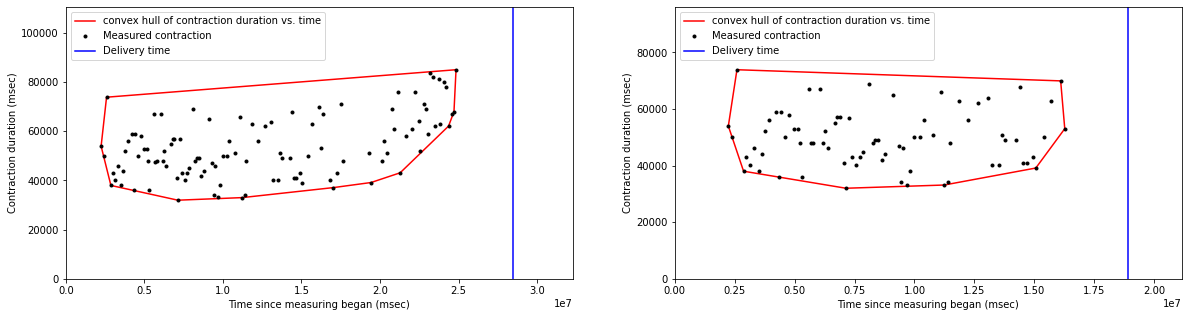

In [178]:

def split(u, v, points):
    # return points on left side of UV
    return [p for p in points if np.cross(p - u, v - u) < 0]
def extend(u, v, points):
    if not points:
        return []
    # find furthest point W, and split search to WV, UW
    w = min(points, key=lambda p: np.cross(p - u, v - u))
    p1, p2 = split(w, v, points), split(u, w, points)
    return extend(w, v, p1) + [w] + extend(u, w, p2)
def calc_convex_hull(points):
    # find two hull points, U, V, and split to left and right search
    u = min(points, key=lambda p: p[0])
    v = max(points, key=lambda p: p[0])
    left, right = split(u, v, points), split(v, u, points)
    
    # find convex hull on each side
    return [v] + extend(u, v, left) + \
           [u] + extend(v, u, right) + [v]

convex_hull_x_datasets = []
convex_hull_y_datasets = []
for i in range(0, len(datasets)):
  points = []
  for j in range(0, len(time_msec_datasets[i])):
    points.append(np.array([time_msec_datasets[i][j], contraction_length_msec_datasets[i][j]]))
  convex_hull = calc_convex_hull(points)
  convex_hull_x =[]
  convex_hull_y =[]
  for point in convex_hull:
    convex_hull_x.append(point[0])
    convex_hull_y.append(point[1])
  convex_hull_x_datasets.append(convex_hull_x)
  convex_hull_y_datasets.append(convex_hull_y)

for i in range(0, len(datasets)):
  plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
  plt.plot(convex_hull_x_datasets[i], convex_hull_y_datasets[i], '-', color='red', label="convex hull of contraction duration vs. time")
plot_datasets()


This convex hull doesn't look like it will work either since the top of the hull hasn't considered any of the lower points of the top part which.
It would have worked much better if it had not been for that outlier at the beginning.

hobbs (https://stats.stackexchange.com/users/44112/hobbs), How did Steve Mould predict his child birth time with contraction duration over time?, URL (version: 2021-06-09): https://stats.stackexchange.com/q/529955

suggests it could have been a windowed min-max. I implemented that below.

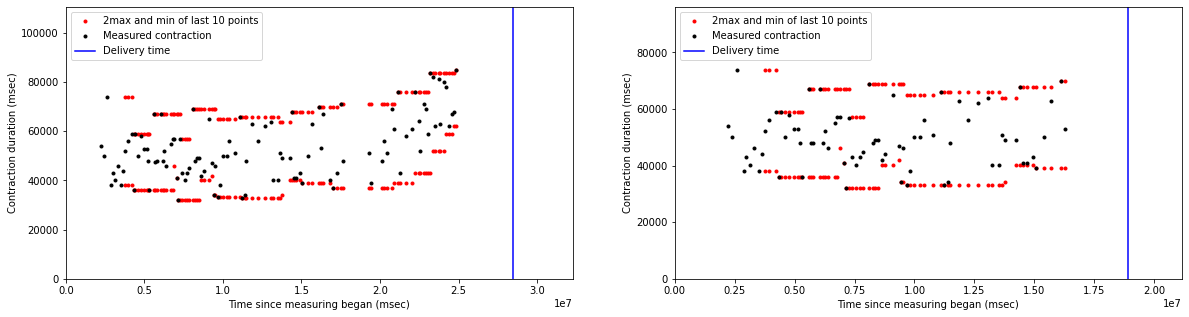

In [179]:
overlapping_windowed_time_msec_datasets = []
overlapping_windowed_max_datasets = []
overlapping_windowed_min_datasets = []
for i in range(0, len(datasets)):
  overlapping_windowed_max = []
  overlapping_windowed_min = []
  
  overlapping_windowed_time_msec = time_msec_datasets[i][WINDOW_SIZE-1:len(contraction_length_msec_datasets[i])]
  for j in range(WINDOW_SIZE-1, len(contraction_length_msec_datasets[i])):
      contraction_sub_array = contraction_length_msec_datasets[i][j-WINDOW_SIZE+1:j+1]
      overlapping_windowed_max.append(max(contraction_sub_array))
      overlapping_windowed_min.append(min(contraction_sub_array))

  overlapping_windowed_time_msec_datasets.append(overlapping_windowed_time_msec)
  overlapping_windowed_max_datasets.append(overlapping_windowed_max)
  overlapping_windowed_min_datasets.append(overlapping_windowed_min)

for i in range(0, len(datasets)):
  plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
  label_str = str(NUM_SIGMAS) + "max and min of last " + str(WINDOW_SIZE) + " points"
  plt.plot(overlapping_windowed_time_msec_datasets[i], overlapping_windowed_max_datasets[i], '.', color='red', label=label_str)
  plt.plot(overlapping_windowed_time_msec_datasets[i], overlapping_windowed_min_datasets[i], '.', color='red')
plot_datasets()

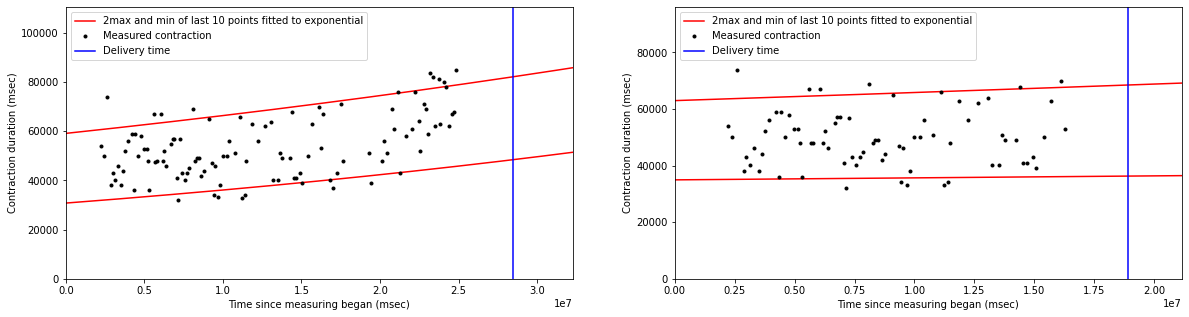

In [180]:

for i in range(0, len(datasets)):
  plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
  label_str = str(NUM_SIGMAS) + "max and min of last " + str(WINDOW_SIZE) + " points fitted to exponential"
  plot_exponential(overlapping_windowed_time_msec_datasets[i], overlapping_windowed_max_datasets[i], label=label_str)
  plot_exponential(overlapping_windowed_time_msec_datasets[i], overlapping_windowed_min_datasets[i])
plot_datasets()


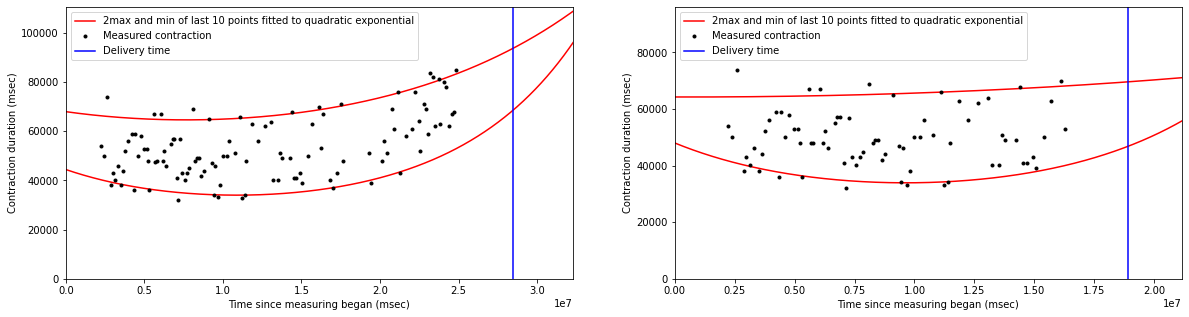

In [181]:

for i in range(0, len(datasets)):
  plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
  label_str = str(NUM_SIGMAS) + "max and min of last " + str(WINDOW_SIZE) + " points fitted to quadratic exponential"
  plot_quadratic_exponential(overlapping_windowed_time_msec_datasets[i], overlapping_windowed_max_datasets[i], label=label_str)
  plot_quadratic_exponential(overlapping_windowed_time_msec_datasets[i], overlapping_windowed_min_datasets[i])
plot_datasets()

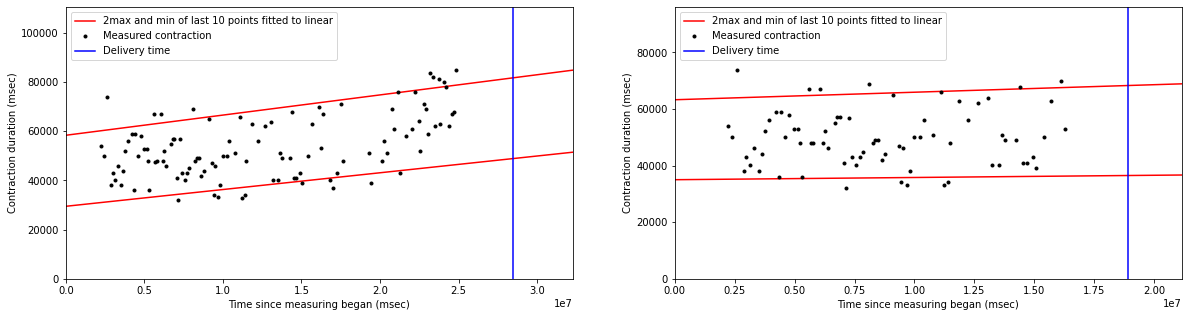

In [182]:

for i in range(0, len(datasets)):
  plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
  label_str = str(NUM_SIGMAS) + "max and min of last " + str(WINDOW_SIZE) + " points fitted to linear"
  plot_linear(overlapping_windowed_time_msec_datasets[i], overlapping_windowed_max_datasets[i], label=label_str)
  plot_linear(overlapping_windowed_time_msec_datasets[i], overlapping_windowed_min_datasets[i])
plot_datasets()

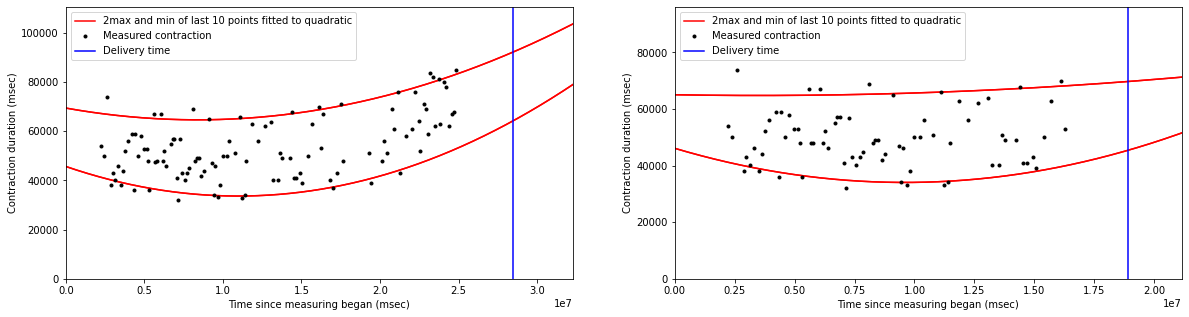

In [183]:

for i in range(0, len(datasets)):
  plt.subplot(SUB_PLOT_ROWS, SUB_PLOT_COLS, i+1)
  label_str = str(NUM_SIGMAS) + "max and min of last " + str(WINDOW_SIZE) + " points fitted to quadratic"
  plot_quadratic(overlapping_windowed_time_msec_datasets[i], overlapping_windowed_max_datasets[i], label=label_str)
  plot_quadratic(overlapping_windowed_time_msec_datasets[i], overlapping_windowed_min_datasets[i])
plot_datasets()